In [24]:
push!(LOAD_PATH, "../src/")
import MockKepler
import plotting
using PyPlot
import utils
reload("plotting")
reload("MockKepler")

In [3]:
# Read in data
combo_file = "../data/combos_grid.json"
rep_file = "../data/representatives.txt"
sim_file = "../data/final_planets_grid.csv"
combos, mocked_stars = MockKepler.load_combos(combo_file);
stars, kois, inj = MockKepler.subsample();
sims = MockKepler.load_sims(sim_file);
sim_array = MockKepler.sims_as_array(sims);
reps = MockKepler.load_representatives(rep_file);

For speed and storage purposes two main things were done that can make things confusing but in the end significantly increase the speed of this analysis.
- Instead of using the full kepler stellar sample, 1000 stars were selected and used as representatives of the others. Each star in the kepler sample has a representative with similar detection efficiency characteristics.
    - rep_file stores the list of kepler stars and their representative (i.e. reps[kepid] is the representative for that kepid)
    - mocked_stars is a list of the representatives in the order that the mock observation data is stored in combos. 
        - (If you want, e.g., the mock observation data for some star then: rep = reps[star]; index = find(rep .== mocked_stars); data=combos[:,:,:,index]
        - This is made easier using sample_combo_indices (created below): For star at index i in the list sample_kepids, the mock observation data can be obtained from combos[:,:,:,sample_combo_indices[i]]
    
- The mock observation data is stored as counts of combinations of observed planets. (this cuts down on file size by a huge amount without losing information except for transit durations)
    - combos is a 4-d array:
        - combos[2:end, combosIndex, simIndex, repIndex] gives the indices of the planets that were observed. (0 means none) 
        - combos[1, combosIndex, simIndex, repIndex] is the cummulative number obs with this combo or the ones before. i.e. combos[1,k,j,i]-combos[1,k-1,j,i] is the number of observations that showed combo k. The cummulative number is used for faster random sampling of combos.

In [4]:
sample_kepids = stars[:kepid].data;
observed_mult = MockKepler.observed_multiplicity(sample_kepids, kois);
sample_combo_indices = MockKepler.kepid_to_combo_index(sample_kepids, mocked_stars, reps);
camp = MockKepler.SimulatedCampaign(combos, sample_kepids, sample_combo_indices, sim_array); # this just packages some data;

In [5]:
# This is an array that gives the probability of each observed multiplicity
# for each star and set of simulations. e.g. mult_probs[1,3,2] is the probability
# of observing 0 planets (base 1 indexing) for the 3rd simulation set around the 
# rep star at index 2 in the mocked_stars list

# mult_probs_resamples adds a 4th dimension to the array and just resamples the 
# simulations for use in some form of bootstrapping. So mult_probs_resamples[:,:,:,i] 
# contains the same information as mult_probs for some resampling of the simulations.
mult_probs = MockKepler.simulated_multiplicity_probs(combos);
mult_probs_resamples = MockKepler.simulated_multiplicity_probs(combos, 10);

Acceptance Rate: 0.811


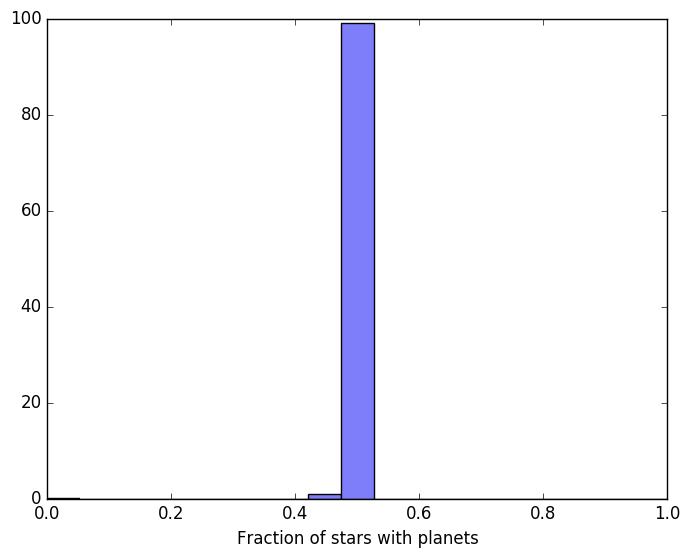

PyObject <matplotlib.text.Text object at 0x36312f0d0>

In [14]:
# Here is a basic example of how to use MCMC to sample the parameters for some model. 
# In this case the model is a one component model using simulation set 4, which corresponds
# to alpha=-0.5, mass=35 
index = 4
function f(p)
    model = zeros(Float64, 12)
    model[index] = p[1]
    MockKepler.multiplicity_lnl(model, sample_combo_indices, observed_mult, mult_probs)
end
chain, lnl = utils.basicMCMC(f, [1], 1000, proposal_width=.006);
models = zeros(Float64, 12, 100)
models[index,:] = chain[end-396:4:end]
# plotting.plot_model_multiplicity(model, camp, observed_mult);
plotting.plot_all(models, camp, kois, dir="none", suffix="")

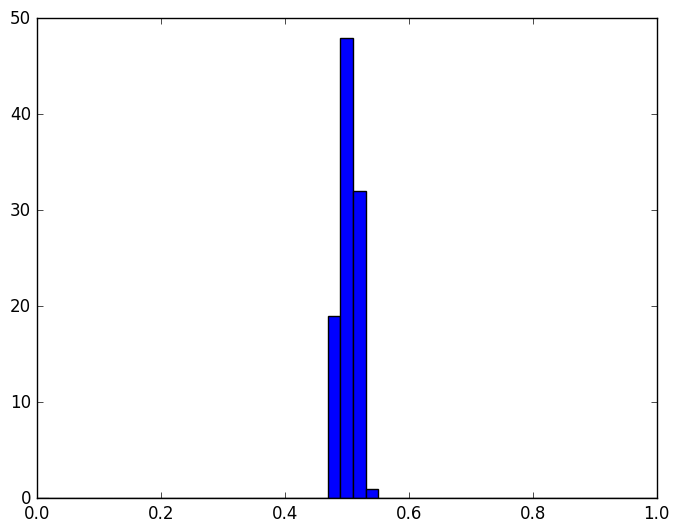

([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0204082,0.0408163,0.0612245,0.0816327,0.102041,0.122449,0.142857,0.163265,0.183673  …  0.816327,0.836735,0.857143,0.877551,0.897959,0.918367,0.938776,0.959184,0.979592,1.0],Any[PyObject <matplotlib.patches.Rectangle object at 0x3267adf90>,PyObject <matplotlib.patches.Rectangle object at 0x3267adf50>,PyObject <matplotlib.patches.Rectangle object at 0x32679c310>,PyObject <matplotlib.patches.Rectangle object at 0x3267a5910>,PyObject <matplotlib.patches.Rectangle object at 0x3267ad810>,PyObject <matplotlib.patches.Rectangle object at 0x326706ad0>,PyObject <matplotlib.patches.Rectangle object at 0x32678fed0>,PyObject <matplotlib.patches.Rectangle object at 0x3267b7750>,PyObject <matplotlib.patches.Rectangle object at 0x3267ad7d0>,PyObject <matplotlib.patches.Rectangle object at 0x3267ad350>  …  PyObject <matplotlib.patches.Rectangle object at 0x3260117d0>,PyObject <matplotlib.patches.Rectangle obje

In [12]:
PyPlot.plt[:hist](sum(models, 1)[:], bins=linspace(0,1,50));

In [99]:
# here is a model with all 12 weights for the simulation sets free
# an initial burn in run is done first. Plot lnl to see if burn in 
# is long enough
function f(p)
    MockKepler.multiplicity_lnl(p, sample_combo_indices, observed_mult, mult_probs)
end
chain, lnl = utils.basicMCMC(f, zeros(Float64,12), 2000, proposal_width=.0002);
chain, lnl = utils.basicMCMC(f, chain[:,end], 10000, proposal_width=.002);

Acceptance Rate: 0.23
Acceptance Rate: 0.1372


Average number of observed systems: 1488.37


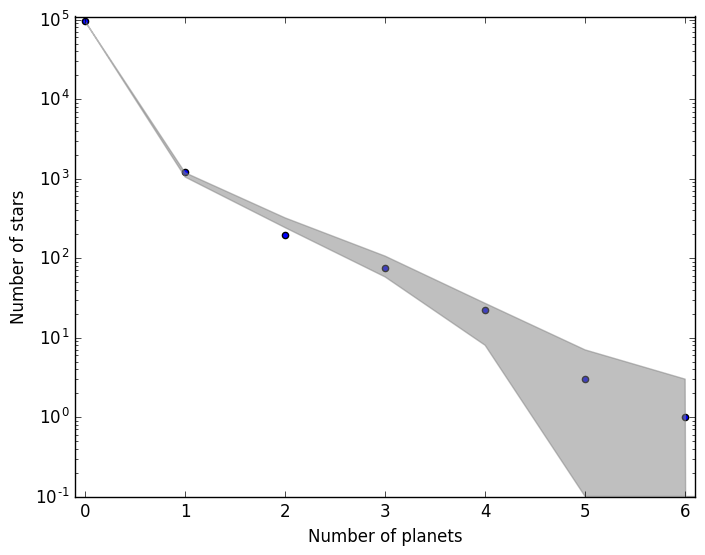

In [100]:
plotting.plot_model_multiplicity(chain[:,end], camp, observed_mult);

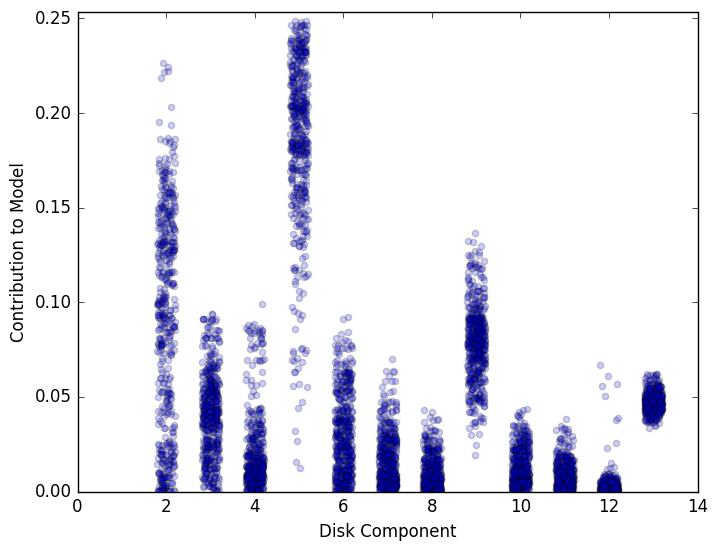

In [101]:
# and here is the distribution sampled for each set (ordered by alpha -0.5 to -2.5 and mass low to high)
plotting.plot_chain(chain)

In [19]:
# here is an example where the posterior is created using ten different resamplings of the simulations.
# Presumably this does a better job in accounting for the error in our description of system architecture
# due to undersampling. Notice the broader distribution in the chain plotted below.
full_chain = ones(12,0)
for i=1:10
    println(i)
    function f(p)
        MockKepler.multiplicity_lnl(p, sample_combo_indices, observed_mult, mult_probs_resamples[:,:,:,i])
    end
    thischain, lnl = utils.basicMCMC(f, ones(12)*.03, 4000, proposal_width=.0002);
    thischain, lnl = utils.basicMCMC(f, thischain[:,end], 100000, proposal_width=.002);
    full_chain = [full_chain thischain]
end

1
Acceptance Rate: 0.89775
Acceptance Rate: 0.34134
2
Acceptance Rate: 0.90625
Acceptance Rate: 0.3587
3
Acceptance Rate: 0.92125
Acceptance Rate: 0.32739
4
Acceptance Rate: 0.90125
Acceptance Rate: 0.35331
5
Acceptance Rate: 0.90575
Acceptance Rate: 0.37074
6
Acceptance Rate: 0.91775
Acceptance Rate: 0.37015
7
Acceptance Rate: 0.92125
Acceptance Rate: 0.35707
8
Acceptance Rate: 0.915
Acceptance Rate: 0.36683
9
Acceptance Rate: 0.90025
Acceptance Rate: 0.33101
10
Acceptance Rate: 0.903
Acceptance Rate: 0.35229


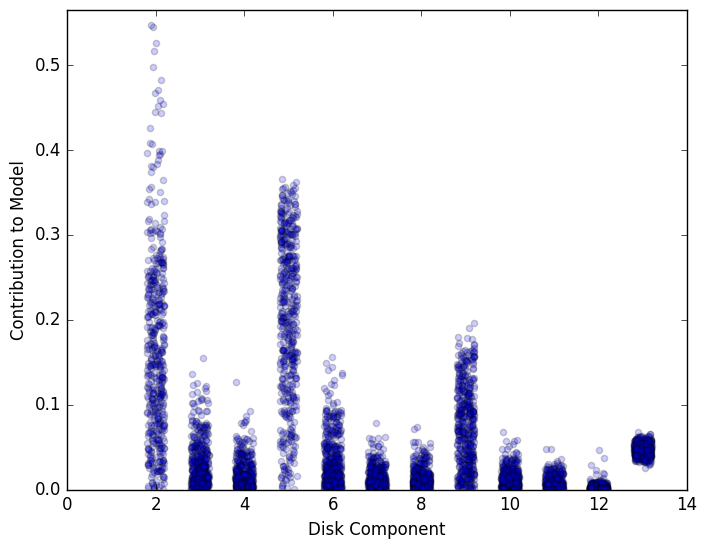

In [20]:
plotting.plot_chain(full_chain)

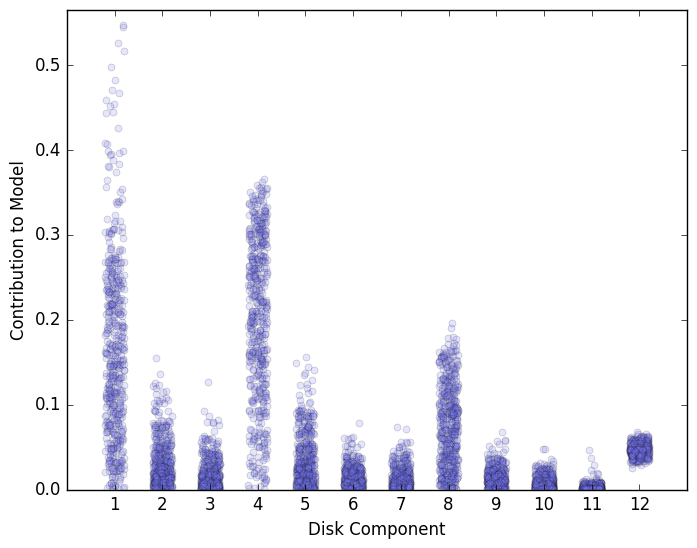

In [39]:
# this function creates a bunch of nice plots and saves them to the specified directory
# with some suffix to identify them from other plots created by this function
plotting.plot_all(full_chain, camp, kois, dir="../plots", suffix="")

### Occurance rates as a function of system architecture

Acceptance Rate: 0.791
Acceptance Rate: 0.8424
Acceptance Rate: 0.677
Acceptance Rate: 0.7242
Acceptance Rate: 0.577
Acceptance Rate: 0.6466


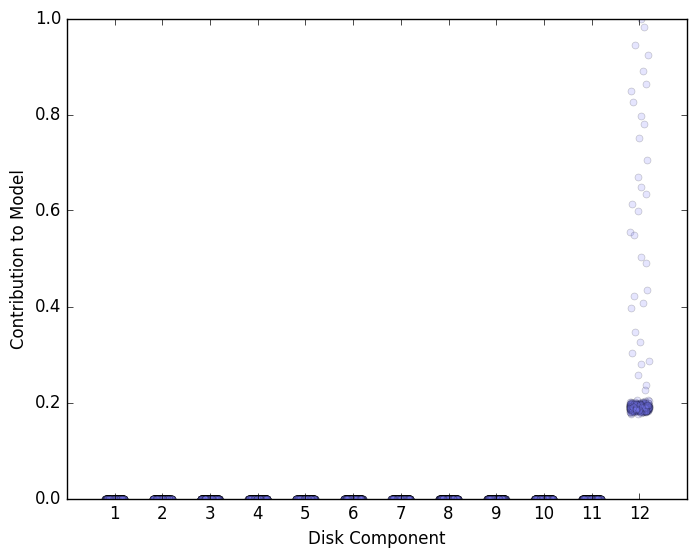

In [41]:
index = 4
function f(p)
    model = zeros(Float64, 12)
    model[index] = p[1]
    MockKepler.multiplicity_lnl(model, sample_combo_indices, observed_mult, mult_probs)
end
chain, lnl = utils.basicMCMC(f, [1], 1000, proposal_width=.006);
chain, lnl = utils.basicMCMC(f, chain[1], 5000, proposal_width=.006);
models = zeros(Float64, 12, length(lnl))
models[index,:] = chain[:]
plotting.plot_all(models, camp, kois, dir="../plots", suffix="_0.5")

index = 8
function f(p)
    model = zeros(Float64, 12)
    model[index] = p[1]
    MockKepler.multiplicity_lnl(model, sample_combo_indices, observed_mult, mult_probs)
end
chain, lnl = utils.basicMCMC(f, [1], 1000, proposal_width=.006);
chain, lnl = utils.basicMCMC(f, chain[1], 5000, proposal_width=.006);
models = zeros(Float64, 12, length(lnl))
models[index,:] = chain[:]
plotting.plot_all(models, camp, kois, dir="../plots", suffix="_1.5")

index = 12
function f(p)
    model = zeros(Float64, 12)
    model[index] = p[1]
    MockKepler.multiplicity_lnl(model, sample_combo_indices, observed_mult, mult_probs)
end
chain, lnl = utils.basicMCMC(f, [1], 1000, proposal_width=.006);
chain, lnl = utils.basicMCMC(f, chain[1], 5000, proposal_width=.006);
models = zeros(Float64, 12, length(lnl))
models[index,:] = chain[:]
plotting.plot_all(models, camp, kois, dir="../plots", suffix="_2.5")

In [43]:
hist(MockKepler.observed_multiplicity(camp.stars, kois), collect(0:8)-.5)

([-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],[95378,1215,198,75,22,3,1,0])